# Trainer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import IPython
import IPython.display

In [2]:
from nn.deepar import create_model
from preprocess.data_generator import DatasetGenerator

### Data

In [3]:
CSV_FILE = "../data/data.csv"

df = pd.read_csv(CSV_FILE)
df[:3]

,t,x,y,z,tx8,tx9,tx10,tx12,tx13,tx14,...,tx25,tx26,tx7,tx6,tx5,tx4,tx3,tx2,tx1,tx0
0,1.666423e+12,-572.51,669.33,686.66,-51.0,-56.0,-59.0,-62.0,-51.0,-57.0,...,-60.0,-59.0,-68.0,-64.0,-62.0,-61.0,-68.0,-70.0,-63.0,-65.0
1,1.666423e+12,-571.78,670.35,685.36,-47.0,-53.0,-58.0,-61.0,-50.0,-56.0,...,-61.0,-60.0,-71.0,-67.0,-63.0,-65.0,-70.0,-70.0,-62.0,-68.0
2,1.666423e+12,-552.27,670.57,686.04,-47.0,-54.0,-58.0,-60.0,-51.0,-55.0,...,-61.0,-60.0,-75.0,-68.0,-64.0,-65.0,-68.0,-71.0,-63.0,-68.0


In [4]:
len(df)

8227

### Data Preprocessing

#### Replace -255 to nan

In [5]:
df = df.replace(-255.0, np.nan)

#### Convert RSSI to Radiance

* improve linearity in dataset?

In [6]:
def Watt2DecibelWatt(w):
    return 10 * np.log10(w);

def DecibelWatt2Watt(dB):
    return np.power(10, dB * 0.1)

In [7]:
def convert_rssi_to_radiance(df):
    rad_df = df.copy()
    for col in list(rad_df.columns)[4:]:
        rad_df[col] = rad_df[col].map(DecibelWatt2Watt, na_action='ignore')
    return rad_df
# rad_df = convert_rssi_to_radiance(df)
rad_df = df.copy()
rad_df[:3]

,t,x,y,z,tx8,tx9,tx10,tx12,tx13,tx14,...,tx25,tx26,tx7,tx6,tx5,tx4,tx3,tx2,tx1,tx0
0,1.666423e+12,-572.51,669.33,686.66,-51.0,-56.0,-59.0,-62.0,-51.0,-57.0,...,-60.0,-59.0,-68.0,-64.0,-62.0,-61.0,-68.0,-70.0,-63.0,-65.0
1,1.666423e+12,-571.78,670.35,685.36,-47.0,-53.0,-58.0,-61.0,-50.0,-56.0,...,-61.0,-60.0,-71.0,-67.0,-63.0,-65.0,-70.0,-70.0,-62.0,-68.0
2,1.666423e+12,-552.27,670.57,686.04,-47.0,-54.0,-58.0,-60.0,-51.0,-55.0,...,-61.0,-60.0,-75.0,-68.0,-64.0,-65.0,-68.0,-71.0,-63.0,-68.0


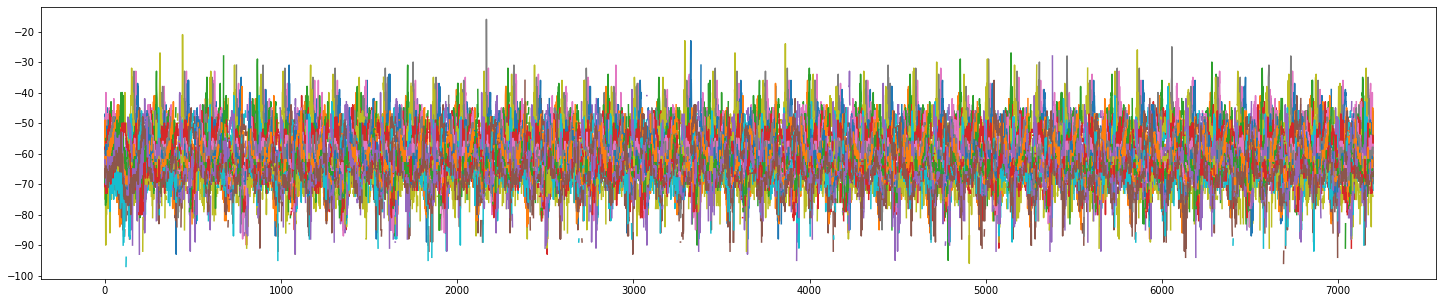

In [8]:
def prep_data(df):
    raw_df = df.copy()
    # keep all 'tx'
    input_df = raw_df[list(df.columns)[4:]].astype('float')
    # only keep 'x','y'
    label_df = raw_df[['x','y','z']]

    plt.figure(figsize=(25,5))
    plt.plot(input_df)
    plt.show()
    
    # concat label with input as new df
    new_df = pd.concat([label_df, input_df], axis=1)
    # get the diff of each rows
    # diff_df = new_df.diff(axis=0)[1:]
    # normalize
    norm_df = (new_df-new_df.mean())/(new_df.std() + 1e-10)
    norm_df = norm_df.interpolate('linear')
    norm_df = norm_df.dropna().reset_index(drop=True)

    return norm_df, new_df
norm_df, new_df = prep_data(df[:7200])

In [9]:
norm_df[:1]

,x,y,z,tx8,tx9,tx10,tx12,tx13,tx14,tx15,...,tx25,tx26,tx7,tx6,tx5,tx4,tx3,tx2,tx1,tx0
0,-1.000839,1.204753,-0.80358,1.476114,0.560466,0.234181,0.400273,1.961136,1.339369,0.806211,...,0.137849,0.360856,-0.082491,0.328767,0.026326,0.150473,-0.496913,-0.690302,0.347341,0.174736


### Create Dataset

In [10]:
columns = list(norm_df)

datagen = DatasetGenerator(data=norm_df,input_width=50,label_width=50,shift=0,columns=list(norm_df),input_columns=columns[3:],
                           label_columns=columns[:3],batch_size=32,partition=(0.8, 0.1, 0.1))

In [30]:
CHECKPOINT_PATH = "../checkpoints/deepar"
HISTORY_PATH = "../checkpoints/deepar/history.csv"
EPOCHS = 100 # epochs on each train() call

In [31]:
class Trainer():
    """
    Trainer -- given dataset and train a model
    """
    def __init__(self, datagen):
        self.dataset_generator = datagen
        self.history = []
    
    def create_checkpoint_manager(self, model):
        ckpt = tf.train.Checkpoint(model=model)
        ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=200)
        return ckpt, ckpt_manager
    
    def train(self):
        dimx = len(self.dataset_generator.input_columns)
        dimz = len(self.dataset_generator.label_columns)
        model = create_model(dim_x=dimx, dim_z=dimz)
        # restore checkpoints if exist
        ckpt, ckpt_manager = self.create_checkpoint_manager(model)
        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))
        # start training model
        train_result, test_result = {}, {}
        train_ds = self.dataset_generator.train_ds
        test_ds = self.dataset_generator.test_ds
        for i in range(EPOCHS):
            start = time.time()
            for data in train_ds:
                train_result = model.train_step(data)

            for data in test_ds:
                test_result = model.test_step(data)
            template = 'Epoch {}, Loss: {:.5f}, RMSE {:.5f}, Test Loss: {:.5f}, Test RMSE {:.5f}, ETC {:.5f} secs'
            print(template.format(i + 1,
                                  train_result['loss'],
                                  train_result['rmse'],
                                  test_result['loss'],
                                  test_result['rmse'],
                                  time.time() - start))
            self.log_history(training_loss=train_result['loss'],
                             training_rmse=train_result['rmse'],
                             test_loss=test_result['loss'],
                             test_rmse=test_result['rmse'])
            # save model parameters
            print('Saving checkpoint for epoch {} at {}'.format(1, ckpt_manager.save()))
            
    def log_history(self, training_loss, training_rmse, test_loss, test_rmse):
        self.history.append([training_loss, training_rmse, test_loss, test_rmse])
        np.savetxt(fname=HISTORY_PATH,
                   X=self.history,delimiter=",",
                   header='training_loss,training_rmse,test_loss,test_rmse',
                   fmt='%f',
                   comments='')

In [32]:
trainer = Trainer(datagen)
trainer.train()

Restoring checkpoint from ../checkpoints/deepar\ckpt-60
Epoch 1, Loss: 4.11965, RMSE 0.57171, Test Loss: 4.13085, Test RMSE 0.57169, ETC 36.67712 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-61
Epoch 2, Loss: 4.11618, RMSE 0.57150, Test Loss: 4.09880, Test RMSE 0.57148, ETC 40.11816 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-62
Epoch 3, Loss: 4.10804, RMSE 0.57128, Test Loss: 4.10880, Test RMSE 0.57126, ETC 40.94740 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-63
Epoch 4, Loss: 4.14863, RMSE 0.57106, Test Loss: 4.15248, Test RMSE 0.57104, ETC 40.76524 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-64
Epoch 5, Loss: 4.11263, RMSE 0.57083, Test Loss: 4.10256, Test RMSE 0.57081, ETC 41.07016 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-65
Epoch 6, Loss: 4.10329, RMSE 0.57060, Test Loss: 4.10965, Test RMSE 0.57058, ETC 40.97424 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt

### Evaluation

In [33]:
from preprocess.data_generator import WindowSplitter


In [34]:
full_datagen = DatasetGenerator(data=norm_df,
                                input_width=1000,
                                label_width=1000,
                                shift=0,
                                columns=list(norm_df),
                                input_columns=columns[3:],
                                label_columns=columns[:3],
                                batch_size=1,
                                partition=(1, 0, 0))

In [35]:
def model_plot2D(model, data, batch_index, title='',warmup_step=10, df_mean=0, df_std=1, x_offset=0, y_offset=0):
    plt.figure(figsize=(20,10))
    inputs, labels = data
    means, _ = model(inputs[:,:,:])
    mean = (means[batch_index, :] * df_std + df_mean) * 0.01 # convert unreal unit to meter
    label = (labels[batch_index, :] * df_std + df_mean) * 0.01 # convert unreal unit to meter
    
    # as a velocity value we need to performance .cumsum(), to convert it back to the change of position
    # plt.plot(mean[warmup_step:, 0].numpy() + x_offset, mean[warmup_step:, 1].numpy() + y_offset, '-r', alpha=0.5)
    
    plt.scatter(mean[warmup_step:, 0].numpy() + x_offset, mean[warmup_step:, 1].numpy() + y_offset, s=30, marker='x', alpha=1)
    plt.scatter(label[warmup_step:,0].numpy() + x_offset, label[warmup_step:,1].numpy() + y_offset, s=30, marker='.', alpha=1)
    plt.legend(labels=['Prediction', 'Ground Truth'], loc='lower left')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title(title)
    plt.axis('equal')
    plt.show()

In [36]:
def restore_model():
    model = create_model(dim_x=len(columns[3:]), dim_z=3)
    # restore checkpoints if exist
    ckpt = tf.train.Checkpoint(model=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=100)
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))
    return model

In [37]:
model = restore_model()

Restoring checkpoint from ../checkpoints/deepar\ckpt-160


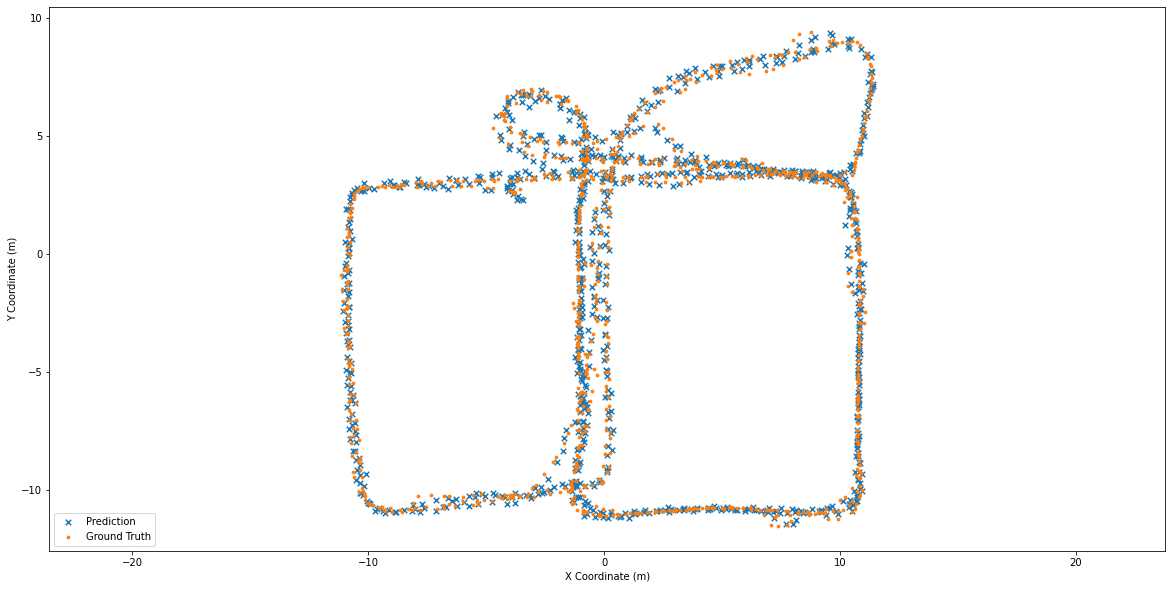

In [38]:
example = next(iter(full_datagen.train_ds))
model_plot2D(model, example, 0, df_mean=new_df.mean()[:3], df_std=new_df.std()[:3] + 1e-10) # [:3] is label columns x,y,z